기본값 : 0  
INFO 로그 필터링 : 1  
WARNING 로그 필터링 : 2  
ERROR 로그 필터링 : 3  

In [20]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

In [22]:
tf.__version__

'2.10.0'

In [23]:
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

https://wikidocs.net/31379

# 트랜스포머 구현

## 에셋 임베딩 레이어

In [24]:
class AssetAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, window_size, d_model, is_decoder=False, **kwargs):
        super(AssetAndPositionEmbedding, self).__init__(**kwargs)
        self.esset_emb = tf.keras.layers.Dense(d_model) #입력 데이터 shape : (batch_size, window_size)
        self.pos_emb = tf.keras.layers.Embedding(window_size, d_model)
        self.is_decoder = is_decoder
        self.__windowsize = window_size

    def call(self, x):
        L = tf.shape(x)[1] if self.is_decoder else self.__windowsize
        
        positions = tf.range(start=0, limit= L, delta=1)
        positions = self.pos_emb(positions)
        x = tf.reshape(x,(-1,L,1))
        x = self.esset_emb(x)
        return x + positions

## 스케일드 닷-프로덕트 어텐션(Scaled dot-product Attention)

In [25]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장 길이)

    # Q와 K의 곱. 어텐션 스코어 행렬.
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 스케일링
    # dk의 루트값으로 나눠준다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

## 멀티 헤드 어텐션(Multi-head Attention)

In [26]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        # d_model을 num_heads로 나눈 값.
        # 논문 기준 : 64
        self.depth = d_model // self.num_heads

        # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)

    # num_heads 개수만큼 q, k, v를 split하는 함수
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 1. WQ, WK, WV에 해당하는 밀집층 지나기
        # q : (batch_size, query의 문장 길이, d_model)
        # k : (batch_size, key의 문장 길이, d_model)
        # v : (batch_size, value의 문장 길이, d_model)
        # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드 나누기
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. 헤드 연결(concatenate)하기
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))

        # 5. WO에 해당하는 밀집층 지나기
        # (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)

        return outputs

## 인코더 레이어

In [27]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 이번 일에서는 패딩이 존재X -> 패딩마스크X

    # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
        'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
        'mask': None
    })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name)

In [28]:
def encoder(window_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 이번 일에서는 패딩이 존재X -> 패딩마스크X

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = AssetAndPositionEmbedding(window_size,d_model)(inputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 인코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                                dropout=dropout, name=f"encoder_layer_{i}",)([outputs])

    return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name)

## 셀프 어텐션(Self-attention)과 룩-어헤드 마스크(Look-ahead mask)

In [29]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return look_ahead_mask[tf.newaxis,tf.newaxis,:,:]

In [30]:
tmp = tf.constant(np.arange(3*5*7).reshape((3,5,7)), dtype=tf.float32)

create_look_ahead_mask(tmp)

<tf.Tensor: shape=(1, 1, 5, 5), dtype=float32, numpy=
array([[[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]]], dtype=float32)>

## 디코더 레이어

In [11]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

    # 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    # 패딩 마스크X

    # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={
        'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
        'mask': look_ahead_mask # 룩어헤드 마스크
    })

    # 잔차 연결과 층 정규화
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
        'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
        'mask': None # 패딩 마스크
    })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask],
        outputs=outputs,
        name=name)

In [12]:
def decoder(forecast_range, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = AssetAndPositionEmbedding(forecast_range,d_model,is_decoder=True)(inputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                                dropout=dropout, name=f'decoder_layer_{i}',)(inputs=[outputs, enc_outputs, look_ahead_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask],
        outputs=outputs,
        name=name)

## 트랜스포머(Transformer)

In [13]:
def transformer(window_size, forecast_range, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

    # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더의 패딩 마스크X

    # 디코더의 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 디코더의 패딩 마스크X

    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(window_size=window_size, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads, dropout=dropout,)(inputs=[inputs]) # 인코더의 입력은 입력 문장과 패딩 마스크

    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(forecast_range=forecast_range, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads, dropout=dropout,)(inputs=[dec_inputs, enc_outputs, look_ahead_mask])

    # 다음 단어 예측을 위한 출력층
    #outputs = tf.keras.layers.Dense(units=forecast_range, name="outputs")(dec_outputs)
    outputs = tf.keras.layers.Dense(units=1, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 어텐션 레이어(enc-dec)

In [14]:
def attention_enc_dec(window_size,d_model,num_heads,name='attention_enc2dec'):
    asset_outputs = tf.keras.Input(shape=(window_size,d_model), name="asset_outputs")
    pos_outputs = tf.keras.Input(shape=(window_size,d_model), name="pos_outputs")
    neg_outputs = tf.keras.Input(shape=(window_size,d_model), name="neg_outputs")
    index_outputs = tf.keras.Input(shape=(window_size,d_model), name="index_outputs")
    
    concat_outputs = tf.keras.layers.concatenate([asset_outputs,pos_outputs,neg_outputs,index_outputs],name = "concatenate")
    #concat_outputs = tf.keras.layers.concatenate([pos_outputs,neg_outputs,index_outputs],name = "concatenate")
    
    enc_outputs = MultiHeadAttention(d_model=d_model,num_heads=num_heads, name="multi_head_attention")(inputs={
        'query': concat_outputs, 'key': concat_outputs, 'value': concat_outputs, 
        'mask': None
    })
    #enc_outputs = MultiHeadAttention(d_model=d_model,num_heads=num_heads, name="multi_head_attention")(inputs={
    #    'query': asset_outputs, 'key': concat_outputs, 'value': concat_outputs, 
    #    'mask': None
    #})
    return tf.keras.Model(inputs=[asset_outputs,pos_outputs,neg_outputs,index_outputs], outputs=enc_outputs, name=name)

## 멀티 인풋 트랜스포머

### 시퀀스 어탠션(sequence attention)

In [15]:
class SeqAttention(tf.keras.layers.Layer):
    def __init__(self, num_seq, window_size, d_model, attmap_dropout=0.1, name="sequence_attention"):
        super(SeqAttention, self).__init__(name=name)
        self.num_seq = num_seq
        self.window_size = window_size
        self.d_model = d_model
        self.attmap_dropout = attmap_dropout
        
        #필요 레이어
        ## 어탠션 맵을 만들 레이어
        self.att_concate = tf.keras.layers.Concatenate(axis=1)
        self.attmap_dense= tf.keras.layers.Dense(self.num_seq*self.d_model)
        self.att_softmax = tf.keras.layers.Softmax()
        
        #어탠션맵 생성 이후 처리
        
        #(+ 이부분 좀 생각해보자. 어쩌면 d_model 방향으로 차례로 넣는걸 해야할지도?)
        self.concate = tf.keras.layers.Concatenate(axis=2) #d_model 방향으로 concatenate 
        self.dense = tf.keras.layers.Dense(self.d_model, activation=None) #
    
    def call(self,query_,key_):
        '''
        input 모양 : 
            쿼리 -> (None, window_size, d_model, num_seq)
            키/밸류 -> (None, num_seq, window_size)
        
        attention map 모양 : (None, 1, d_model, num_seq)
        
        output 모양:
            (None, window_size, 2 * d_model, num_seq)
        '''
        
        #Attention map 만들기
        min_seq = tf.math.reduce_min(key_,axis=1) #(None, window_size)
        avg_seq = tf.math.reduce_mean(key_,axis=1) #(None, window_size)
        max_seq = tf.math.reduce_max(key_,axis=1) #(None, window_size)
        
        att_input = self.att_concate([min_seq,avg_seq,max_seq]) #(None, 3 * window_size)
        att_score = self.attmap_dense(att_input) #(None, d_model * num_seq)
        att_map = self.att_softmax(att_score)
        att_map = tf.reshape(att_map,[-1,1,self.d_model,self.num_seq]) #(None, 1, d_model, num_seq)
        
        #Attention
        att_out = tf.math.multiply(query_, att_map)
        
        #쿼리와의 concatenate
        concat_query = self.concate([query_, att_out]) #(None, window_size, 2*d_model, num_seq)
        
        #(None, window_size, 2*d_model, num_seq) -> (None, window_size, d_model, num_seq)
        concat_query = tf.transpose(concat_query,[0,1,3,2])
        concat_query = tf.reshape(concat_query,[-1,2*self.d_model])
        out = self.dense(concat_query)
        out = tf.reshape(out,[-1,self.window_size,self.num_seq,self.d_model])
        out = tf.transpose(out,[0,1,3,2])
        
        return out

### 멀티 인풋 트랜스포머

In [16]:
def multi_input_transformer(num_seq,window_size,num_layers,dff,d_model,num_heads,dropout,name=None):
    inputs = tf.keras.Input(shape=(num_seq,window_size), name="inputs")
    
    inputs_split = tf.split(inputs, num_or_size_splits=num_seq, axis=1)
    for i in range(num_seq):
        inputs_split[i] = tf.reshape(inputs_split[i],(-1,window_size))
    
    siamese_enc = encoder(window_size=window_size, num_layers=num_layers, dff=dff,
                              d_model=d_model, num_heads=num_heads, dropout=dropout,name = "siamese_encoder")
    
    outputs_concat = []
    for i in range(num_seq):
        #siamese 구조
        outputs = siamese_enc(inputs=[inputs_split[i]])
        #outputs의 shape = (None,window_size,d_model)
        outputs = tf.reshape(outputs,(-1,window_size,d_model,1))
        
        outputs_concat.append(outputs)
    outputs_concat = tf.keras.layers.Concatenate(axis=3,name = "concatenate")(outputs_concat)
    
    outputs_concat_att = SeqAttention(num_seq=num_seq,
                                      window_size=window_size,
                                      d_model=d_model,
                                      attmap_dropout=0.1,
                                      name="sequence_attention")(query_ = outputs_concat, key_=inputs)
    
    reduce_mean_outputs = tf.math.reduce_mean(outputs_concat_att,axis=3)#어탠션 수행 예정!
    return tf.keras.Model(inputs=[inputs], outputs=reduce_mean_outputs, name=name)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-10-31 18:34:37.611605: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


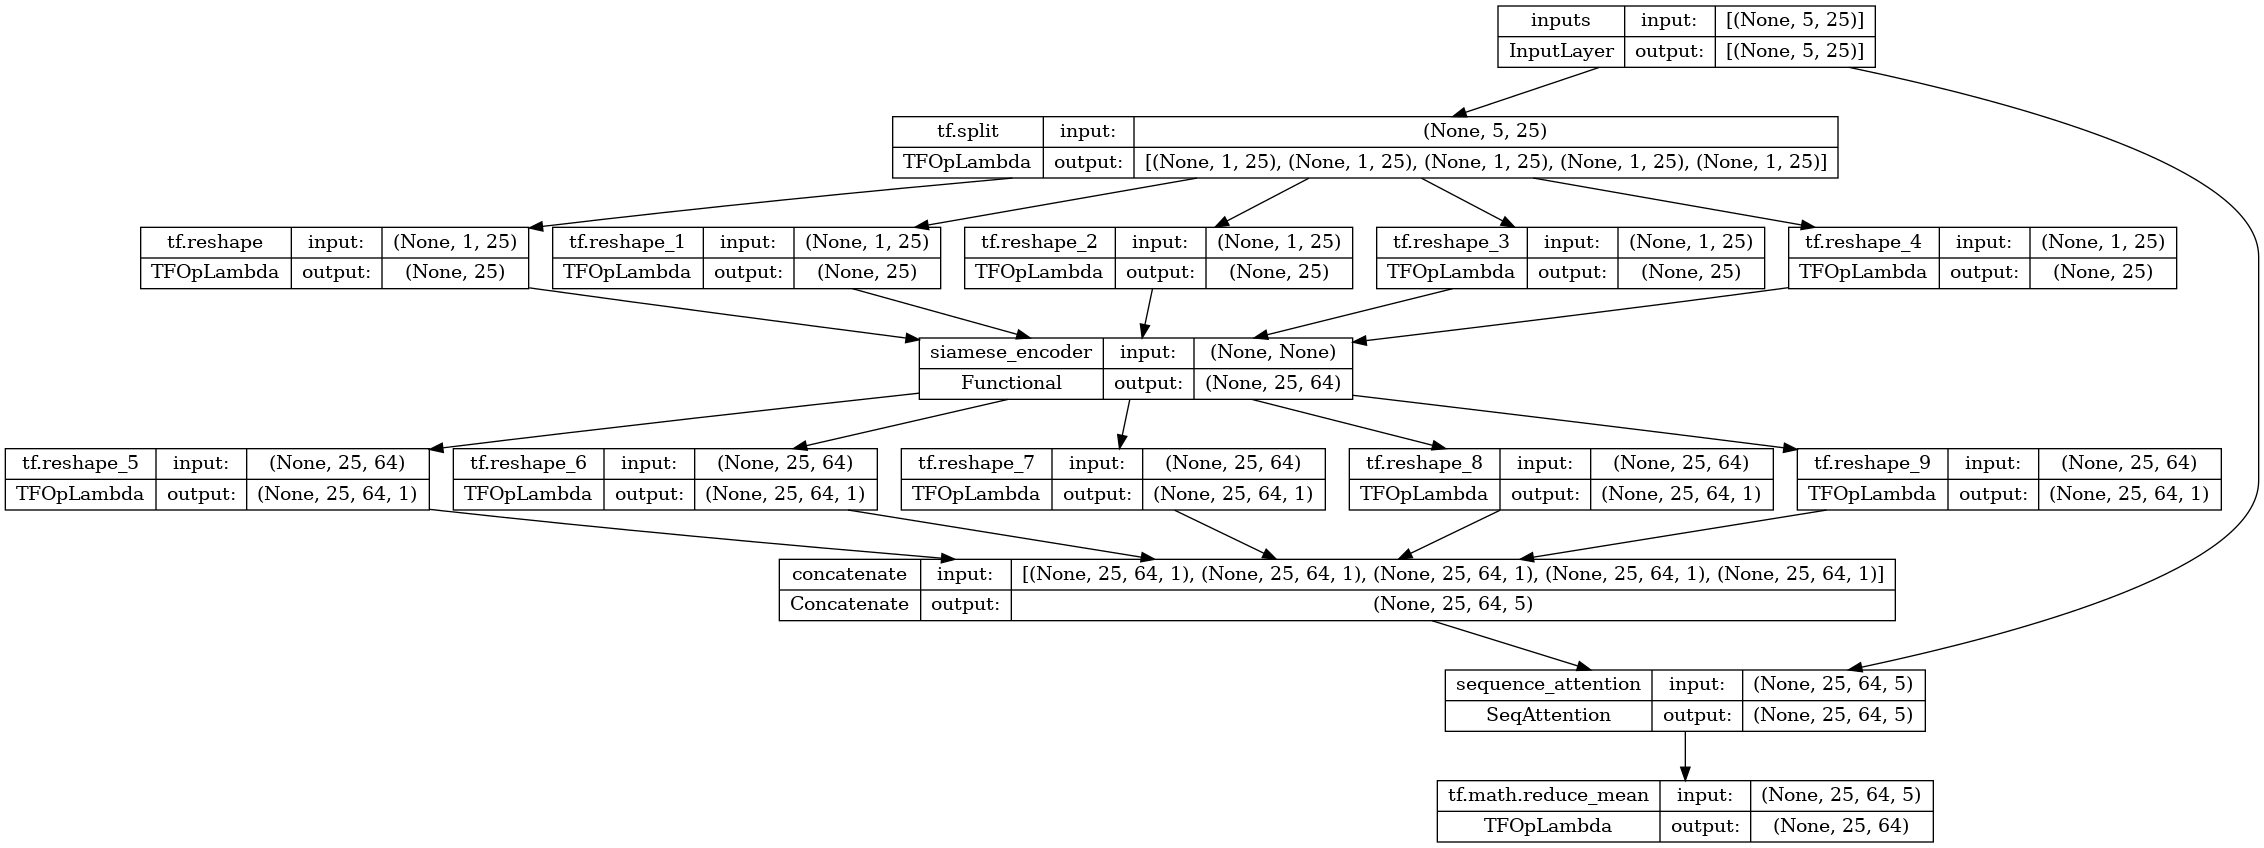

In [17]:
tf.keras.backend.clear_session()

pos_enc = multi_input_transformer(num_seq = 5,
                                  window_size=25,
                                  num_layers=4,
                                  dff=128,
                                  d_model=64,
                                  num_heads=8,
                                  dropout=0.1,
                                  name='multi_input_transformer')
tf.keras.utils.plot_model(pos_enc, to_file='./imgs/multi_inputs_transformer.png', show_shapes=True)

## 멀티 인코더 트랜스포머

In [18]:
def MEaI_transformer(window_size, forecast_range, P, N, I, num_layers, dff,
                     d_model, num_heads, dropout,
                     name="MEaI_transformer"):

    # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    # 상관주 인코더의 입력 <- 여러 벡터가 인풋으로 들어가는데 이걸 해결할 방법은? MI-LSTM은 어떻게 처리했더라??
    pos_inputs = tf.keras.Input(shape=(P,window_size), name="pos_inputs")
    neg_inputs = tf.keras.Input(shape=(N,window_size), name="neg_inputs")
    
    # 인덱스 인코더의 입력 <- 여러 벡터가 인풋으로 들어가는데 이걸 해결할 방법은? MI-LSTM은 어떻게 처리했더라??
    index_inputs = tf.keras.Input(shape=(I,window_size), name="index_inputs")
    
    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 디코더의 룩어헤드 마스크(첫번째 서브층).
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    
    #에셋 인코더
    Target_seq_outputs = encoder(window_size=window_size, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads, dropout=dropout,name = "Target_seq_encoder")(inputs=[inputs])
    
    pos_outputs = multi_input_transformer(num_seq=P,window_size=window_size,num_layers=num_layers,dff=dff,
                                              d_model=d_model,num_heads=num_heads,dropout=dropout,name="pos_siamese_encoder")(inputs=[pos_inputs])
    neg_outputs = multi_input_transformer(num_seq=N,window_size=window_size,num_layers=num_layers,dff=dff,
                                              d_model=d_model,num_heads=num_heads,dropout=dropout,name="neg_siamese_encoder")(inputs=[neg_inputs])
    index_outputs = multi_input_transformer(num_seq=I,window_size=window_size,num_layers=num_layers,dff=dff,
                                              d_model=d_model,num_heads=num_heads,dropout=dropout,name="index_siamese_encoder")(inputs=[index_inputs])
    
    #concatenate-attention
    enc_outputs = attention_enc_dec(window_size,d_model,num_heads,name='attention_enc2dec')(inputs=[Target_seq_outputs,pos_outputs,neg_outputs,index_outputs])#(None,25,64)
    
    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(forecast_range=forecast_range, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads, dropout=dropout,)(inputs=[dec_inputs, enc_outputs, look_ahead_mask])

    # 다음 예측을 위한 출력층
    #outputs = tf.keras.layers.Dense(units=forecast_range, name="outputs")(dec_outputs)
    outputs = tf.keras.layers.Dense(units=1, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs,pos_inputs,neg_inputs,index_inputs, dec_inputs], outputs=outputs, name=name)

# 모델 생성

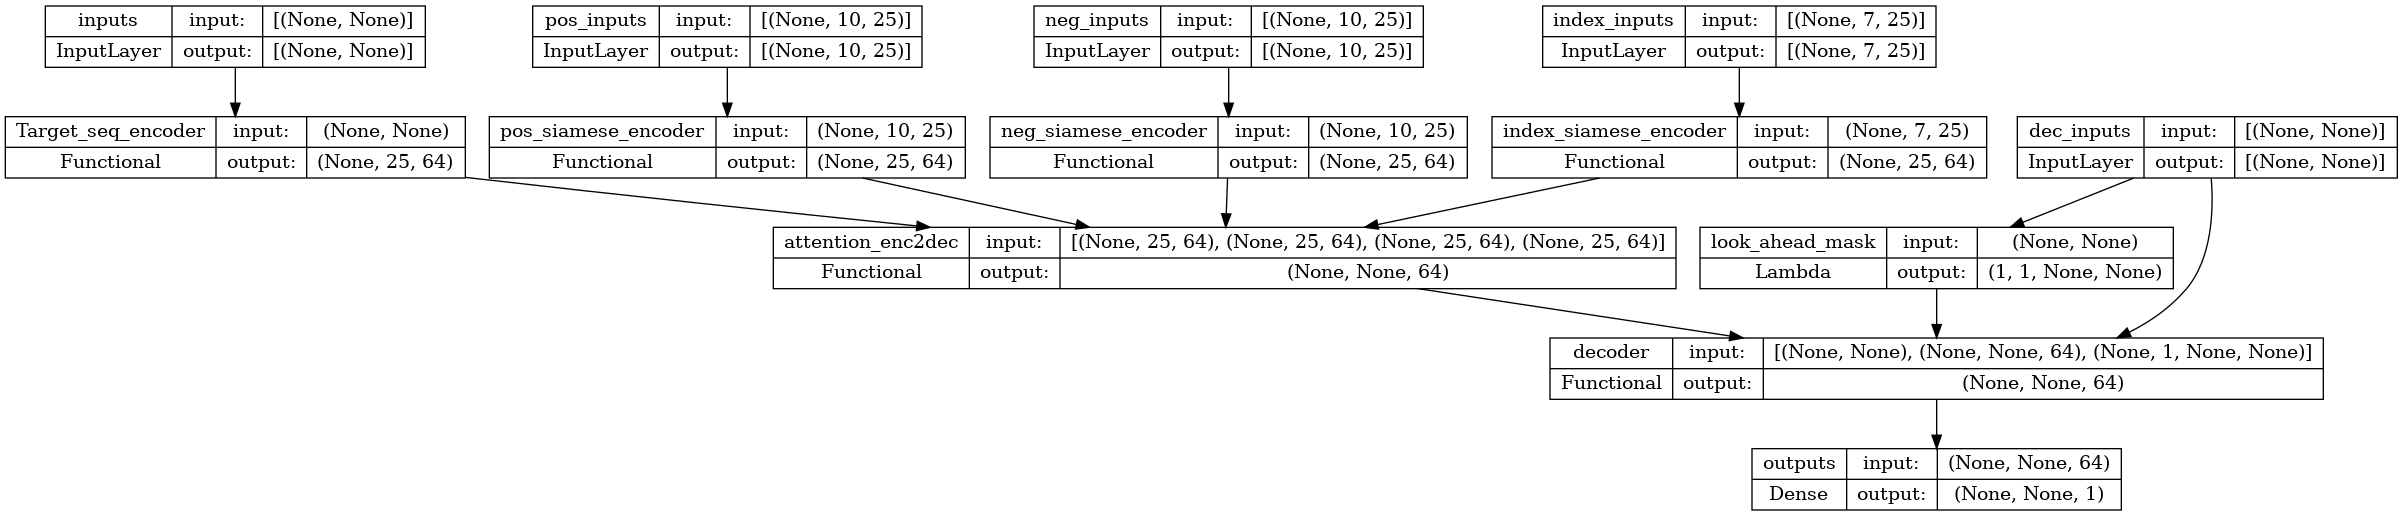

In [19]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
WINDOW_SIZE = 25
FORECAST_RANGE = 20
NUM_LAYERS = 4  #인코더, 디코더의 층 수
DFF = 128 #트랜스포머 내부의 피드-포워드 신경망의 은닉층 크기(입력층, 출력층은 d_model) 
D_MODEL = 64 #인코더, 디코더에서의 정해진 출력 크기 = 임베딩 벡터의 차원
NUM_HEADS = 8 #트랜스포머 내 어텐션에서 여러개로 분할 후 병렬로 어탠션 수행함. 이때의 병렬의 수
DROPOUT = 0.1

model = MEaI_transformer(
    window_size = WINDOW_SIZE,
    forecast_range = FORECAST_RANGE,
    P=10,
    N=10,
    I=7,
    num_layers = NUM_LAYERS,
    dff = DFF,
    d_model = D_MODEL,
    num_heads = NUM_HEADS,
    dropout = DROPOUT,
    name="MEaI_transformer")

tf.keras.utils.plot_model(model, to_file='./imgs/MEaI_transformer.png', show_shapes=True)

# 모델 학습!

In [ ]:
#model.compile(optimizer = tf.keras.optimizers.Adam(),
#              loss = tf.keras.losses.MeanSquaredError(),
#              metrics=[tf.keras.metrics.RootMeanSquaredError(),
#                       tf.keras.metrics.MeanAbsolutePercentageError()]
#             )
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.MeanSquaredError()
             )

In [ ]:
callback_path = './transformer/ver_0824'

os.makedirs(f'{callback_path}/ckpt', exist_ok=True)
ckpt_path = callback_path+'/ckpt/model_{epoch:03d}-{val_loss:.4f}.hdf5'
callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    monitor='val_loss',
    save_best_only = True,
    verbose=1
)

os.makedirs(f'{callback_path}/tsbd', exist_ok=True)
callback_tsbd = tf.keras.callbacks.TensorBoard(f'{callback_path}/tsbd')

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.75 ** (epoch-5)
callback_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
lr = 0.001
e = np.arange(20)

r = [scheduler(e_,lr) for e_ in e]
plt.plot(e,r)

한 에폭에 약 400s

In [ ]:
history = model.fit(train_dataset, epochs=20, validation_data=test_dataset, verbose = 1, callbacks=[callback_ckpt,callback_scheduler,callback_tsbd])

```bash
tensorboard --logdir=~/바탕화면/main_drive/LeeJaeYong/2.Transformer/transformer/ver1/tsbd
```
-------
혹시 이런 에러가 뜬다면...
> E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES

```bash
/usr/bin/google-chrome-stable --enable-blink-features=ShadowDOMV0,CustomElementsV0,HTMLImports
```